In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
import cv2  # OpenCV for image processing
from transformers import ViTForImageClassification, ViTFeatureExtractor
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification
from PIL import Image
from torchvision import datasets

# Import model.

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Test with: {device}")

model = ViTForImageClassification.from_pretrained(
'google/vit-base-patch16-224-in21k',
num_labels=4,
problem_type="multi_label_classification"
)

# print(model.vit.encoder.layer[-1])

state_dict = load_file("./model_retrained_bestVal.safetensors")
model.load_state_dict(state_dict)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

Test with: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:
class ViTDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)  # Load image and label
        image = feature_extractor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)  # Apply feature extractor
        return image, label

# Overfit Test.

In [113]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from transformers import AutoModelForImageClassification, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Initialize lists to store predictions and true labels
y_pred = []
y_true_list = []
y_probs = []

In [114]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from torch.nn.functional import softmax

def test(test_loader):
    # Initialize variables for accuracy
    correct = 0
    total = 0

    # Model evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            # Get model outputs
            outputs = model(pixel_values=images)
            probs = softmax(outputs.logits, dim=1)
            preds = torch.argmax(outputs.logits, dim=1)

            # Update accuracy
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Display images with predicted and true labels
            for i in range(images.size(0)):
                img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy array for visualization
                img = (img - img.min()) / (img.max() - img.min())  # Normalize image for proper display

                true_class = labels[i].item()
                predicted_class = preds[i].item()

                y_pred.append(test_dataset.classes[predicted_class])
                y_true_list.append(test_dataset.classes[true_class])
                y_probs.append(probs[i].cpu().numpy())

                print(f"True: {test_dataset.classes[true_class]} | Pred: {test_dataset.classes[predicted_class]}")

    # Print overall test accuracy
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

## Dataset kết hợp.

In [115]:
!rm -rf /content/Dataset1/.ipynb_checkpoints

In [116]:
# Setup the dataset and dataloader
test_dataset = ViTDataset(root="/content/Dataset1")
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
test(test_loader)

True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: Lung Opacity
True: COVID | Pred: Normal
True: COVID | Pred: Lung Opacity
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: Lung Opacity
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: Normal
True: COVID | Pred: Lung Opacity
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: COVID | Pred: COVID
True: CO

F1 Score: 0.9601161442894759
Precision: 0.9617316249617643
Recall: 0.9602083333333333
AUC-ROC: 0.9965431134259259


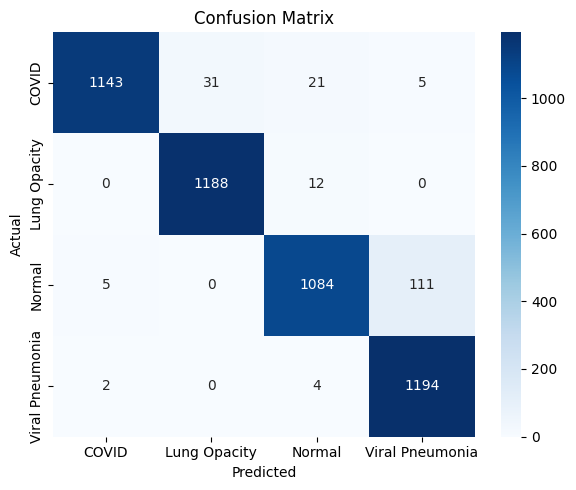

In [117]:
# Calculate Precision, Recall, and Confusion Matrix
precision = precision_score(y_true_list, y_pred, average='macro')
recall = recall_score(y_true_list, y_pred, average='macro')
f1 = f1_score(y_true_list, y_pred, average='macro')

labels = ["COVID", "Lung Opacity", "Normal", "Viral Pneumonia"]
y_true_bin = label_binarize(y_true_list, classes=labels)

roc_auc = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')
cm = confusion_matrix(y_true_list, y_pred, labels=labels)


print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC:", roc_auc)

# Plot as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [118]:
#1: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
#2: https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images
#3: https://www.kaggle.com/datasets/thomasnibb/image-classification-covid19-xray
#4: https://www.kaggle.com/datasets/fsang2692/lung-area-specific-covid19-xray-dataset
#5: https://www.kaggle.com/datasets/nourmahmoud/covid19-digital-xrays-forgery-dataset
#6: https://www.kaggle.com/datasets/yazanqiblawey/sars-mers-xray-images-dataset
#7: https://www.kaggle.com/datasets/kamildinleyici/covid-normal-viral-opacity-v2

In [119]:
import os
folder_list = ['/content/Dataset1/COVID', '/content/Dataset1/Lung Opacity', '/content/Dataset1/Normal', '/content/Dataset1/Viral Pneumonia']
for folder in folder_list:
    file_count = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
    print(f"Number of files in {folder}: {file_count}")

Number of files in /content/Dataset1/COVID: 1200
Number of files in /content/Dataset1/Lung Opacity: 1200
Number of files in /content/Dataset1/Normal: 1200
Number of files in /content/Dataset1/Viral Pneumonia: 1200


In [121]:
# os.remove('/content/Dataset1/Lung Opacity/30.jpg')

In [120]:
# import shutil
# shutil.rmtree('/content/Dataset1/Lung Opacity')  # Replace with the directory's path